In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/EnKF/")

"/media/mat/HDD/EnKF/Project.toml"

In [2]:
using Revise
using EnKF
using Distributions
using DocStringExtensions
using LinearAlgebra
using Plots
using ProgressMeter
using DifferentialEquations

┌ Info: Recompiling stale cache file /home/mat/.julia/compiled/v1.1/EnKF/oXK06.ji for EnKF [685896a8-a41b-11e9-3419-3315e75b5d74]
└ @ Base loading.jl:1184
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1186


We are interested in simulating an anharmonic oscillator
                $$\frac{d^2 x}{dt^2} -\Omega^2 x  + \Lambda^2 x^3 = 0$$
                discretized as:
                $$ x(k+1) - 2x(k) + x(k-1) = \omega^2 x(k) -\lambda x(k)^3$$

In [6]:
N = 10
ω = 3.5*10^-2
λ = 3.0*10^-3

0.003000000000000001

In [7]:
function (::PropagationFunction)(t::Float64, ENS::EnsembleState{N, TS}) where {N, TS}
    for (i,s) in enumerate(ENS.S)
        ENS.S[i] = [2.0+ ω^2 - λ^2*s[1]^2  -1.0; 1.0  0.0]*deepcopy(s)
    end
    return ENS
end

In [8]:
fprop = PropagationFunction()

PropagationFunction()

Define measurement function m

In [9]:
function (::MeasurementFunction)(t::Float64, s::TS) where TS
    return s[1]
end

In [10]:
function (::MeasurementFunction)(t::Float64)
    return [1.0 0.0]
end

In [11]:
m = MeasurementFunction()

MeasurementFunction()

Define  real measurement function z

In [12]:
Z = AdditiveInflation(MvNormal(zeros(1),[10.0]))

AdditiveInflation{1}(DiagNormal(
dim: 1
μ: [0.0]
Σ: [100.0]
)
)

In [13]:
function (::RealMeasurementFunction)(t::Float64, ENS::EnsembleState{N, TZ}) where {N, TZ}
    return Z(ENS)
end

In [14]:
z = RealMeasurementFunction()

RealMeasurementFunction()

Define covariance inflation

In [36]:
A = IdentityInflation()

IdentityInflation()

Define noise covariance

In [37]:
ϵ = AdditiveInflation(MvNormal(zeros(1), 1e-3*I))

AdditiveInflation{1}(IsoNormal(
dim: 1
μ: [0.0]
Σ: [1.0e-6]
)
)

In [38]:
N = 50
NZ = 3
isinflated = false
isfiltered = false
isaugmented = false

false

In [39]:
x₀ = [0.0, 1.0]
ens = initialize(N, MvNormal(x₀, 2.0*I))
estimation_state = [deepcopy(ens.S)]

true_state = [deepcopy(x₀)]

1-element Array{Array{Float64,1},1}:
 [0.0, 1.0]

In [40]:
g = FilteringFunction()

FilteringFunction()

In [41]:
enkf = ENKF(N, NZ, fprop, A, g, m, z, ϵ, isinflated, isfiltered, isaugmented)

MethodError: MethodError: Cannot `convert` an object of type AdditiveInflation{1} to an object of type AdditiveInflation{3}
Closest candidates are:
  convert(::Type{T}, !Matched::T) where T at essentials.jl:154
  AdditiveInflation{3}(::Any) where NS at /media/mat/HDD/EnKF/src/inflation.jl:65

### Ensemble Kalman filter estimation

In [30]:
Δt = 1.0
T = 0.0:Δt:2500.0

@showprogress for (n,t) in enumerate(T)
    
#     push!(true_state, deepcopy(tmp))
    
    
    
    global ens
#     enkf.f(t, ens)
    t, ens = enkf(t, Δt, ens)
    
    push!(estimation_state, deepcopy(ens.S))
    

end

MethodError: MethodError: Cannot `convert` an object of type Float64 to an object of type Array{Float64,1}
Closest candidates are:
  convert(::Type{Array{Float64,1}}, !Matched::Sundials.NVector) at /home/mat/.julia/packages/Sundials/OdI66/src/nvector_wrapper.jl:56
  convert(::Type{Array{Float64,1}}, !Matched::Ptr{Sundials._generic_N_Vector}) at /home/mat/.julia/packages/Sundials/OdI66/src/nvector_wrapper.jl:77
  convert(::Type{Array{T,1}}, !Matched::Distributions.ZeroVector{T}) where T at /home/mat/.julia/packages/Distributions/tfkz4/src/utils.jl:28
  ...

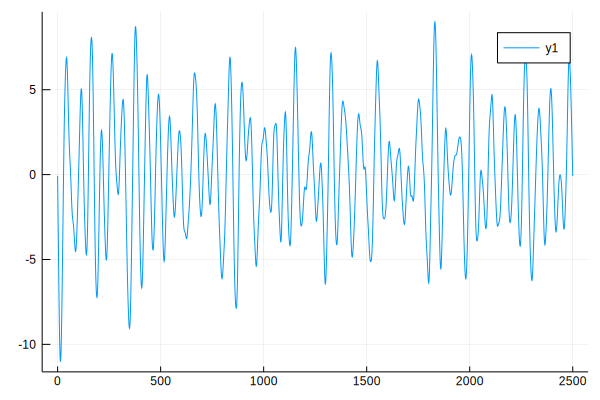

In [22]:
# ŝ =  hcat(mean.(estimation_state)...)

# plot(T,ŝ[1,1:end-1])
# plot!(T,ŝ[2,1:end-1])
# plot!(T,ŝ[3,1:end-1])


let 
s =  hcat(mean.(estimation_state)...)
    plot(T, s[1,1:end-1])
end

In [57]:
s =  hcat(mean.(estimation_state)...)

2×2502 Array{Float64,2}:
 0.113869  -0.377108  -0.868541  -1.36101   …  -17.732   -16.9089  -16.0731
 0.604985   0.113869  -0.377108  -0.868541     -18.5387  -17.732   -16.9089